In [1]:
### to make sure the notebook imports the correct package, append the path to sys.path so python can find the package
# import sys
# sys.path.append('/home/nathan/public_thermo_flux')

from cobra.io import load_json_model
import thermo_flux
from thermo_flux.core.model import ThermoModel
from equilibrator_api import  Q_
import pandas as pd
from thermo_flux.io import helper_load as hl

import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
INPUT_FOLDER= 'datafiles/'

# In this first part, we will start from a cobra model and build a thermo-model following the steps described in the protocol 

Import (json/xml/sbml) model from BiGG

In [3]:
from cobra.io import load_json_model
model=load_json_model('iMM904.json')

#set objective to biomass
model.objective = model.reactions.BIOMASS_SC5_notrace

model.repair()
#we keep rxn directions or  Note that we will make all reactions reversible
for rxn in model.reactions:
    rxn.lower_bound=-500 if rxn.lower_bound==-999999.0 else rxn.lower_bound
    rxn.upper_bound=500 if rxn.upper_bound==999999.0 else rxn.upper_bound

#reset O2 exchange bound
model.optimize().to_frame().loc['BIOMASS_SC5_notrace']['fluxes']
model.reactions.EX_o2_e.bounds=(-500,0)

print(model.optimize().to_frame().loc['BIOMASS_SC5_notrace']['fluxes'])
model.optimize().to_frame().loc[[rxn.id for rxn in model.boundary]]



Set parameter Username
Academic license - for non-commercial use only - expires 2026-06-03
0.974881420673357


,fluxes,reduced_costs
EX_epistest_SC_e,0.0,-96.275549
EX_epist_e,0.0,-1.676719
EX_ergst_e,0.0,-1.722387
EX_ergstest_SC_e,0.0,-96.321217
EX_13BDglcn_e,0.0,-0.196130
...,...,...
EX_xyl__D_e,0.0,-0.163442
EX_xylt_e,0.0,-0.176421
EX_rib__D_e,0.0,-0.163442
EX_zymst_e,0.0,-1.620476


Step 1 - Physical and Biochemical parameters

In [4]:
tmodel=ThermoModel(model,split_biomass=True, add_charge_exchange= True)

Initializing component contribution object...
cxcalc is not installed, operating in read-only mode. A local cache may be loaded, but no compounds can be created. Install cxcalc and obtain a ChemAxon license to enable compound creation.
Copying default Zenodo compound cache to iMM904_compound.sqlite
Loading compounds from iMM904_compound.sqlite
added reaction:  biomass_ce: biomass_c <=> biomass_e
added reaction:  biomass_EX: biomass_e <=> 
added reaction:  charge_ce: charge_e <=> charge_c
added reaction:  EX_charge: charge_e <=> 
added reaction:  charge_cm: charge_m <=> charge_c
added reaction:  charge_cx: charge_x <=> charge_c
added reaction:  charge_cr: charge_r <=> charge_c
added reaction:  charge_cv: charge_v <=> charge_c
added reaction:  charge_cg: charge_g <=> charge_c
added reaction:  charge_cn: charge_n <=> charge_c


In [5]:
#define the biochemical parameters of the model

tmodel.phi={'ec': Q_(-0.06,'volt'), 'cm': Q_(-0.16,'volt'),'cx':Q_(0,'volt'),'cr':Q_(0,'volt'),'cv':Q_(0,'volt'),'cg':Q_(0,'volt'),'cn':Q_(0,'volt')}
tmodel.pH={'c':Q_(7),'e':Q_(5),'m':Q_(7.4),'r':Q_(7),'v':Q_(5.5),'g':Q_(7),'x':Q_(7),'n':Q_(7)} #On the intracellular pH of baker’s yeast(r), Martinez-Munoz et al. 2008(v), Juan Llopis et al 1998 (g), 7 is default pH

#change max drGcalc_drGt
tmodel._max_drG=Q_(1e6,'kJ/mol') #max is already 1e8 shouldnt need to change


Step 2 - Definition of metabolites

In [6]:
from warnings import warn

In [7]:
tmodel.get_compounds(search = True)

[████████████████████████████████████████] 1236/1236 charge_n                  



[<ThermoMetabolite biomass_c at 0x31a3ce850>,
 <ThermoMetabolite biomass_e at 0x31a3cfed0>]

In [8]:
#define biomass parameters 
#if the biomass formula is not automatically calcualted it's important to specifiy the hydrogen atoms in biomass to ensure correct proton balancing 
tmodel.metabolites.biomass_c.formula = 'H67'
tmodel.metabolites.biomass_e.formula = 'H67'

#manually define charge of cytochrome C so electron movement is correctly calcualted
tmodel.metabolites.focytc_m.charge = 2
tmodel.metabolites.focytc_m.redox= True #define as redox metabolite 
tmodel.metabolites.ficytc_m.charge = 3
tmodel.metabolites.ficytc_m.redox = True

### Step 3 - metabolites formation energies

When specifying the value of `dfGprime` for the biomass metabolite, we should plug in the values in units of **J/gDW**. This differs from all the other reactions in the model, for which values of **kJ/mol** are used.

The reason for this discrepancy has to do with the units of the fluxes.

For a normal reaction:
$g_{diss, rxn} = \Delta_rG \times v = (kJ/mol) \times (mmol/gDW/h) = (10^3 J/mol) \times (10^{-3} mol/gDW/h) = J/gDW/h$

For the biomass reaction:
$g_{diss, bio} = \Delta_fG_{bio} \times \mu = (J/gDW) \times (gDW/gDW/h) = J/gDW/h $

Since thermoflux handles all reactions the same when determining the gibbs energy dissipation rate (multiplying $v$ by $\Delta_rG$), we have to **pretend** that the biomass formation energy has units of kJ/mol. E.g:
`tmodel.metabolites.biomass_c.dfGprime = Q_(701.767, "kJ/mol")` (where 701.767 is the formation energy of E.coli biomass at cytosolic pH, in units of J/gDW)

In [9]:
#define biomass properties
tmodel.reactions.BIOMASS_SC5_notrace.id='biomass_c' #update biomass reaction name for convenience

tmodel.metabolites.biomass_c.dfG0 = Q_(-3.04,'kJ/mol')*1000 #From Battley 1991, *1000 for mmol flux units (actual units here are J/gDW)
tmodel.metabolites.biomass_e.dfG0 = Q_(-3.04,'kJ/mol')*1000


### Step 4a - Transporters curation 

In [10]:
#idenfity transporters where the transported metabolite is empty
#these could either be redox reactions or proton pumps just moving electrons (charge) and protons 
#or they could be transporters with chemcial transformation during the transport process
for reaction in tmodel.reactions:
    if len(reaction.compartments) > 1:
        if thermo_flux.tools.drg_tools.calc_transported_mets(reaction) == {}:
            print(reaction.id, reaction, thermo_flux.tools.drg_tools.calc_transported_mets(reaction))


ASPOcm ASPOcm: asp__L_c + fad_m --> fadh2_m + h_c + iasp_c {}
ATPS ATPS: atp_c + h2o_c --> adp_c + h_e + pi_c {}
DHORD4i DHORD4i: dhor__S_c + q6_m --> orot_c + q6h2_m {}
DOLPMTcer DOLPMTcer: dolp_c + gdpmann_c --> dolmanp_r + gdp_c {}
DXHPScm DXHPScm: h2o_c + q6_m + spmd_c --> 13dampp_c + 4abutn_c + q6h2_m {}
D_LACDcm D_LACDcm: 2.0 ficytc_m + lac__D_c --> 2.0 focytc_m + pyr_c {}
FDNG FDNG: for_c + h_c + q6_m --> co2_c + q6h2_m {}
FRDcm FRDcm: fadh2_m + fum_c --> fad_m + succ_c {}
L_LACD2cm L_LACD2cm: 2.0 ficytc_m + lac__L_c --> 2.0 focytc_m + pyr_c {}
NADH2_u6cm NADH2_u6cm: h_c + nadh_c + q6_m --> nad_c + q6h2_m {}


In [11]:
## add proton transport reactions ##the directions are constrained by pH gradients

tmodel.add_proton_exchange()

added reaction:  H_cm: h_m <=> h_c
added reaction:  H_cx: h_x <=> h_c
added reaction:  H_cr: h_r <=> h_c
added reaction:  H_cv: h_v <=> h_c
added reaction:  H_cg: h_g <=> h_c
added reaction:  H_cn: h_n <=> h_c


In [12]:
## add transporter variants for all phosphate transporters

for rxn in [r for r in tmodel.reactions if len(r.compartments) > 1 and any(m.id.split('_')[0] == 'pi' for m in r.metabolites)
            and not any(m.id.split('_')[0] == 'atp' for m in r.metabolites )]:
    new_reactions = thermo_flux.tools.drg_tools.add_transporter_varaints(rxn,balance_charge=True,add_charge_neutral = True, round_dp=2)
    if new_reactions is not None:
        if len(new_reactions) > 0:
            for new_reaction in new_reactions:
                print(new_reaction)

PIt2m0: 1.83 h_c + pi_c <=> 2.0 h_m + pi_m
PIt2v0: 1.83 h_c + pi_c <=> 1.14 h_v + pi_v


### Step 5 - charge and proton balancing

In [13]:
for rxn in tmodel.reactions:
    thermo_flux.tools.drg_tools.reaction_balance(rxn, balance_charge=True, balance_mg=False)

manually curate all reactions that gave a warning

In [14]:
#ATPS3v is vacuolar ATP synthase transporting three protons per ATP
tmodel.reactions.ATPS3v.transported_h = {'v': 3.0, 'c': -3.0}
thermo_flux.tools.drg_tools.reaction_balance(tmodel.reactions.ATPS3v, balance_charge=True, balance_mg=False)


In [15]:
tmodel.reactions.ASPOcm.transported_h= {'m': 2.0, 'c': -2.0}
tmodel.reactions.ASPOcm.transported_charge= {'m': -2.0, 'c': 2.0}
thermo_flux.tools.drg_tools.reaction_balance(tmodel.reactions.ASPOcm, balance_charge=True, balance_mg=False)

In [16]:
tmodel.reactions.ATPS.transported_h={'c':-1,'e':1}
thermo_flux.tools.drg_tools.reaction_balance(tmodel.reactions.ATPS, balance_charge=True, balance_mg=False)

In [17]:
#DHORD4i
tmodel.reactions.DHORD4i.transported_h = {'m': 2.0, 'c': -2.0}
tmodel.reactions.DHORD4i.transported_charge= {'m': -2.0, 'c': 2.0}
thermo_flux.tools.drg_tools.reaction_balance(tmodel.reactions.DHORD4i, balance_charge=True, balance_mg=False)

In [18]:
#DXHPScm is fine

In [19]:
# D_LACDcm
tmodel.reactions.D_LACDcm.transported_charge= {'m': 2.0, 'c': -2.0}
thermo_flux.tools.drg_tools.reaction_balance(tmodel.reactions.D_LACDcm, balance_charge=True, balance_mg=False)

In [20]:
##FDNG
tmodel.reactions.FDNG.transported_h = {'m': 2.0, 'c': -2.0}
tmodel.reactions.FDNG.transported_charge= {'m': -2.0, 'c': 2.0}
thermo_flux.tools.drg_tools.reaction_balance(tmodel.reactions.FDNG, balance_charge=True, balance_mg=False)

In [21]:
#FRDcm ## opposite then others h transport rxn we did until now
tmodel.reactions.FRDcm.transported_h = {'m': -2.0, 'c': 2.0}
tmodel.reactions.FRDcm.transported_charge= {'m': 2.0, 'c': -2.0}
thermo_flux.tools.drg_tools.reaction_balance(tmodel.reactions.FRDcm, balance_charge=True, balance_mg=False)

In [22]:
# L_LACD2cm
tmodel.reactions.L_LACD2cm.transported_charge= {'m': 2.0, 'c': -2.0}
thermo_flux.tools.drg_tools.reaction_balance(tmodel.reactions.L_LACD2cm, balance_charge=True, balance_mg=False)

In [23]:
# NADH2_u6cm
tmodel.reactions.NADH2_u6cm.transported_h = {'m': 2.0, 'c': -2.0}
tmodel.reactions.NADH2_u6cm.transported_charge= {'m': -2.0, 'c': 2.0}
thermo_flux.tools.drg_tools.reaction_balance(tmodel.reactions.NADH2_u6cm, balance_charge=True, balance_mg=False)

In [24]:
##ATPS3v
tmodel.reactions.ATPS3v.transported_h = {'v': 3.0, 'c': -3.0}
thermo_flux.tools.drg_tools.reaction_balance(tmodel.reactions.ATPS3v, balance_charge=True, balance_mg=False)
tmodel.reactions.ATPS3v

Reaction identifier,ATPS3v
Name,ATP synthase vacuole
Memory address,0x304340190
Stoichiometry,adp_v + 3.0 charge_c + 3.0 h_c + pi_v --> atp_v + 3.0 charge_v + h2o_v + 3.021815 h_v ADP C10H12N5O10P2 + 3.0 charge + 3.0 H+ + Phosphate --> ATP C10H12N5O13P3 + 3.0 charge + H2O H2O + 3.021815 H+
GPR,YBR127C and YDL185W and YEL027W and YEL051W and YGR020C and YHR026W and YHR039C_A and YKL080W and...
Lower bound,0.0
Upper bound,500


In [25]:
#DOLPMTcer involved chemcial transformation of dolp. We assume transport of dolmanp for thermodynamic calcualtion
tmodel.reactions.DOLPMTcer.transported_mets = {tmodel.metabolites.dolmanp_r: -1}
thermo_flux.tools.drg_tools.reaction_balance(tmodel.reactions.DOLPMTcer, balance_charge=True, balance_mg=False)



In [26]:
#change max flux to 500 for all reactions

tmodel.reactions.get_by_id("biomass_EX").bounds = (0,500)
tmodel.reactions.get_by_id("biomass_c").bounds = (0,500)
tmodel.reactions.get_by_id("biomass_ce").bounds = (0,500)


for rxn in tmodel.reactions:
    rxn.lower_bound = -500 if rxn.lower_bound == -1000 else rxn.lower_bound
    rxn.upper_bound = 500 if rxn.upper_bound == 1000 else rxn.upper_bound
tmodel.objective = tmodel.reactions.biomass_EX

### Step 6 - Calculation of Gibbs energy of reactions
Add thermodynamic constraints and parameters

In [27]:
### retrieve dfG0 values from equilibrator and add drG0 to the reactions in the model
tmodel.update_thermo_info(fit_unknown_dfG0=False,search=True,report=True)


Identifying compounds...


[████████████████████████████████████████] 1244/1244 Mg_n                                                                                                                                                                                                                                   

Estimating dfG0'...


ficytc_m 0 kilojoule / mole
focytc_m 0 kilojoule / mole
biomass_c 0 kilojoule / mole
biomass_e 0 kilojoule / mole
[████████████████████████████████████████] 1244/1244 Mg_n                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

[████████████████████████████████████████] 1595/1595 PIt2v0                                                                                                                                                                                                                                                 



,stoichiometry,balanced,transporter,transported_mets,transported_h,transported_charge,priority
ASPOcm,asp__L_c + 2.0 charge_m + fad_m + h_m --> 2.0 ...,True,True,None,"{'m': 2.0, 'c': -2.0}","{'m': -2.0, 'c': 2.0}",True
ATPS,atp_c + charge_c + h2o_c + 0.259271 h_c --> ad...,True,True,None,"{'c': -1, 'e': 1}",None,True
NADH2_u6cm,2.0 charge_m + h_c + nadh_c + q6_m --> 2.0 cha...,True,True,None,"{'m': 2.0, 'c': -2.0}","{'m': -2.0, 'c': 2.0}",True
FRDcm,2.0 charge_c + fadh2_m + fum_c --> 2.0 charge_...,True,True,None,"{'m': -2.0, 'c': 2.0}","{'m': 2.0, 'c': -2.0}",True
DXHPScm,h2o_c + q6_m + spmd_c --> 13dampp_c + 4abutn_c...,True,True,None,"{'m': 2.0, 'c': -2.0}",None,True
...,...,...,...,...,...,...,...
EX_asn__L_e,asn__L_e -->,False,False,None,None,None,False
EX_hdcea_e,hdcea_e -->,False,False,None,None,None,False
EX_hdca_e,hdca_e -->,False,False,None,None,None,False
EX_h_e,h_e <=>,False,False,None,None,None,False


### Step 7 - Establishment of the thermodynamic-stoichiometric solution space
Note : In our curation of the iMM904 model, due to the limited information available for the membrane potential of organelles, we chose to allow the free leakage of ions (charges) across the membrane. 
Allowing free movement of charges between compartments prevents over-constraining the model to potentially incorrect information.
For more detailed analysis of charge transport or models where more information is available on membrane physiology then a constraint on the second law could be added for these charge transport reactions.  

In [28]:
#ignore snd for charge - simplification as we don't have accurate values for electrical potential in all the compartments
for rxn in tmodel.reactions:
    if 'charge' in rxn.id and 'EX' not in rxn.id:#charge reactions are constrained by 2nd law 
        print(rxn.id,rxn.ignore_snd)
        rxn.ignore_snd=True
        print(rxn.id,rxn.ignore_snd)
        

#tmodel.reactions.EX_charge.ignore_snd=True

charge_ce False
charge_ce True
charge_cm False
charge_cm True
charge_cx False
charge_cx True
charge_cr False
charge_cr True
charge_cv False
charge_cv True
charge_cg False
charge_cg True
charge_cn False
charge_cn True


In [29]:
# Store the indices of all reactions -  it allows to easily link reaction id and reaction indexes

map_rxn_id = {rxn.id: index for index, rxn in enumerate(tmodel.reactions)}

map_met_id = {met.id: index for index, met in enumerate(tmodel.metabolites)}

#good practice will be to save them in a separate csv file

In [30]:
# add the TFBA variables to the model
tmodel.m = None #reset the gurobi model object in case you're re-running this cell 
tmodel.add_TFBA_variables(gdiss_constraint = True, sigmac_limit = (4000/tmodel.T.m), error_type = 'covariance',qnorm='sep_norm',alpha=0.95)
tmodel.m.update()

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


In [31]:
# # thermo_flux.solver.gurobi.model_start(tmodel,'fixed_dir_firstTFBA_ENS_8.sol', ignore_vars=['all'],fix_vars=['qm','fluxes'],fix='start')
# thermo_flux.solver.gurobi.model_start(tmodel,'yeast_regression_d8.sol', ignore_vars=['all'],fix_vars=['qm'],fix='bound')


In [32]:
import thermo_flux.solver
import thermo_flux.solver.gurobi


tmodel.m.params.NonConvex=2
tmodel.m.params.IntFeasTol=1e-6
tmodel.m.params.OptimalityTol=1e-6
tmodel.m.params.TimeLimit=60*1 #1 minute


tmodel.m.optimize()
# thermo_flux.solver.gurobi.compute_IIS(tmodel)

Set parameter IntFeasTol to value 1e-06
Set parameter TimeLimit to value 60
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 25.0.0 25A362)

CPU model: Apple M3 Max
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 16223 rows, 13556 columns and 351774 nonzeros
Model fingerprint: 0x409180ce
Model has 166 quadratic constraints
Model has 489 general constraints
Variable types: 11961 continuous, 1595 integer (1595 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+06]
  RHS range        [7e-15, 1e+06]
Presolve removed 9775 rows and 7412 columns
Presolve time: 0.43s
Presolved: 6792 rows, 6144 columns, 292971 nonzeros
Presolved model has 86 bilinear constraint(s)

Solving non-convex MIQCP

Variable types: 4837 continuous, 1307 integer (1307 binary)

Root relaxation: objective

In [21]:
##saving model in mps format
# tmodel.m.write('fixed_dir_firstTFBA_ENS_9.mps')
# ## and solution (all variables final values) in .sol format
# tmodel.m.write('fixed_dir_firstTFBA_ENS_9.sol')

## Running TFBA without fixing qm (drG_error) is (i) much longer and (ii) less accurate, because the model can tune drG_error values to maximize growth.
To fix this issue, we will run a regression to experimental data in the part 2, forcing the model to provide a set drG_error values that matches the data.

### First we load the regression data (from Canelas et al., 2011.)
The regression data must be in a specific format before it can be used in the regression function. We process the input dataframe 

In [33]:
reg_data = hl.excel_to_df(f'{INPUT_FOLDER}/FLUX_CONC_data_Canelas_yeast.xlsx')
##first process flux data
reg_data['dvmeas'] = reg_data['dvmeas'].reset_index()
reg_data['dvmeas'].columns = ['cond','rxn','mean_sd','Value']
reg_data['dvmeas'] = reg_data['dvmeas'].replace({'biomass':'biomass_EX'})
reg_data['dvmeas'] = reg_data['dvmeas'].pivot(index=['cond', 'rxn'], columns='mean_sd', values='Value').rename_axis(None, axis=1)
flux_data = reg_data['dvmeas']
##then process metabolite data
reg_data['dmetsmeas'] = reg_data['dmetsmeas'].reset_index()
reg_data['dmetsmeas'].columns = ['cond','met','mean_sd','Value']
reg_data['dmetsmeas'] = reg_data['dmetsmeas'].pivot(index=['cond', 'met'], columns='mean_sd', values='Value').rename_axis(None, axis=1)
metabolite_data = reg_data['dmetsmeas']
###We can select the conditions that we are going to use
conditions = reg_data[('cond')].index.to_list()
###for this example, we will regress to the last condition only.
conditions = conditions[-1:]
##To fit whole cell concentration data we also attribute relative volume fractions to each compartment
volume_data = pd.DataFrame({cond: {'c': 0.925, 'm': 0.075} for cond in conditions}).T ## here cytosol is 92.5% and mitochondria is 7.5% of the cell volume

### It is also possible to bound the concentration of extracellular metabolites to experimental values, in this case we would :
# 1)load them
# 2)bound either the tmodel metabolite concentration bounds
# 3)or build the gurobi model and then bound the ln_conc variable for the corresponding metabolites

In [34]:
flux_data.index = flux_data.index.set_levels([''.join(('EX_', str(level).replace('_EX', '_e'))) if 'biomass' not in str(level) else str(level) for level in flux_data.index.levels[1]], level=1)
flux_data.index = flux_data.index.set_levels(flux_data.index.get_level_values(1).str.replace('EX_co2tot_e','EX_co2_e').unique(), level=1)
#replace EX_glc-D_e with EX_glc__D_e
flux_data.index = flux_data.index.set_levels(flux_data.index.get_level_values(1).str.replace('EX_glc-D_e','EX_glc__D_e').unique(), level=1)

## then build the gurobi model and add fitting variables

In [35]:
# add the TFBA variables to the model
tmodel.m = None #reset the gurobi model object in case you're re-running this cell 
tmodel.add_TFBA_variables(gdiss_constraint = False, sigmac_limit = (5000/tmodel.T.m), error_type = 'covariance',qnorm='sep_norm',alpha=0.95)
##qnorm set to sep_norm uses indepedent bounds for each coefficient in qm and is MUCH faster than qnorm 2
tmodel.m.update()

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


In [36]:
###The regression function is : 
# 1) adding variables for whole cell concentration for metabolites that are in the metabolomics data 
# 2) adding constraints for the whole cell concentration and the corresponding compartmental concentrations
# 3) modifies the objective of the gurobi model so that it is now maximizing biomass but
# ## minimizing the sum of the squared residuals of the fluxes and concentrations

tmodel.regression(conditions, flux_data, metabolite_data, volume_data,
                   conc_fit=True, flux_fit=True, drG_fit=False, resnorm=1, qm_resnorm = 1,
                   error_type='covariance', conc_units = 'mM')

## to ensure good fit to extracellular fluxes, we can bound the exchange fluxes to the experimental values
#make up lower and upper bounds from the confidence interval given the std
CI=2.6
flux_data['lb'] = flux_data['mean'] - CI*flux_data['sd']
flux_data['ub'] = flux_data['mean'] + CI*flux_data['sd']

##here we have build the gurobi model so we bound the flux variables v 
for cond_index,cond in enumerate(conditions):
    flux_data_cond = flux_data.loc[cond]
    for rxn_id in flux_data_cond.index:
        idx_in_model = map_rxn_id[rxn_id]
        #the mvars dictionary is a dictionary of dictionaries, the first key is the condition index, the second key is the reaction index
        tmodel.mvars['v'][cond_index][idx_in_model].lb = flux_data_cond.loc[rxn_id,'lb']
        tmodel.mvars['v'][cond_index][idx_in_model].ub = flux_data_cond.loc[rxn_id,'ub']
    


In [37]:
### to help with numerics, we can set a minimum abs threshold for the bounds and constraints
threshold = 1e-6
new_bound=0
for var in tmodel.m.getVars():
    if (abs(var.ub) < threshold) & (abs(var.ub) != 0):
        var.ub = new_bound if var.ub >0 else -new_bound
        # print(var.varName,var.ub)
    if (abs(var.lb) < threshold) & (abs(var.lb) != 0):
        var.lb = -new_bound if var.lb <0 else new_bound
        # print(var.varName,var.lb)
# Iterate over the constraints
for constraint in tmodel.m.getConstrs():
    # Get the RHS value
    rhs_value = constraint.RHS

    # Check if the RHS value is less than the threshold
    if (abs(rhs_value) < threshold) & (rhs_value != 0):
        constraint.RHS = new_bound if rhs_value >0 else -new_bound
        # print(constraint.ConstrName,constraint.RHS)

In [38]:
### gurobi model parameters are set with the .params attributes
tmodel.m.params.TimeLimit=60*5
tmodel.m.params.FuncNonlinear=1 ##this parameter is essential for the accuracy of the exponential function (whole cell concentration) approximations
tmodel.m.optimize()


Set parameter TimeLimit to value 300
Set parameter FuncNonlinear to value 1
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 25.0.0 25A362)

CPU model: Apple M3 Max
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 16395 rows, 13608 columns and 351949 nonzeros
Model fingerprint: 0x7e27a288
Model has 538 general constraints
Variable types: 12013 continuous, 1595 integer (1595 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [5e-02, 1e+06]
  RHS range        [2e-06, 1e+06]
Presolve removed 10480 rows and 7960 columns
Presolve time: 0.55s
Presolved: 6160 rows, 5649 columns, 274756 nonzeros
Presolved model has 49 nonlinear constraint(s)

Solving non-convex MINLP

Variable types: 4466 continuous, 1183 integer (1183 binary)

Root relaxation: objective 5.334620e+02, 3978 iterations, 0.21 seconds (0.60 work units)

    Nodes    |    Current Node    |   

In [ ]:
## save the solution file, that we will later use to fix qm 
tmodel.m.write(f'yeast_regression_d8.sol')

In [ ]:
### debug  by computing the minimal set of constraints that make the model infeasible (IIS)
# thermo_flux.solver.gurobi.compute_IIS(tmodel)


## Next we visualize the regression fits
todo : make easy function to plot the regression fits

,level_0,rxn,mean,fitted,sd,residual,L2_residual
d8_EX_o2_e,d8,EX_o2_e,-4.20,-5.056590,0.420,2.039499e+00,24.437307
d8_EX_co2_e,d8,EX_co2_e,18.10,20.258989,1.270,1.699991e+00,36.084293
d8_EX_glc__D_e,d8,EX_glc__D_e,-10.23,-10.872827,0.410,1.567870e+00,198.201144
d8_EX_glyc_e,d8,EX_glyc_e,0.06,0.060000,0.003,2.312965e-15,397.603600
d8_EX_ac_e,d8,EX_ac_e,0.67,0.670000,0.074,0.000000e+00,70.292362
...,...,...,...,...,...,...,...
d7_EX_co2_e,d7,EX_co2_e,14.00,NaN,0.980,NaN,NaN
d7_EX_etoh_e,d7,EX_etoh_e,8.70,NaN,0.505,NaN,NaN
d7_EX_glc__D_e,d7,EX_glc__D_e,-7.62,NaN,0.300,NaN,NaN
d7_EX_glyc_e,d7,EX_glyc_e,0.02,NaN,0.001,NaN,NaN


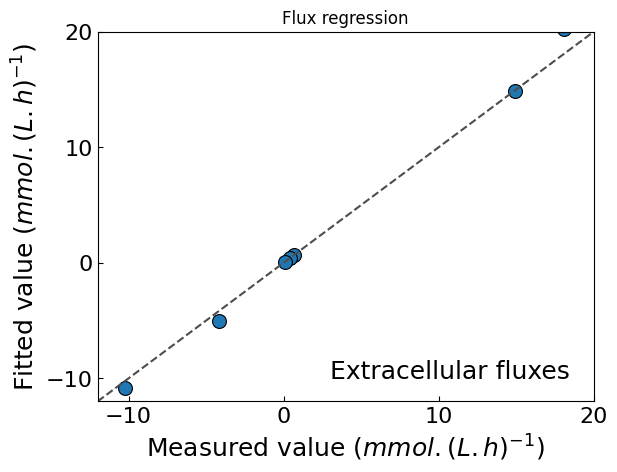

In [39]:
##flux fit plot
##plot error bars 
#ax.errorbar(xd, yd, xerr=yerr, fmt='none', capsize=2, zorder=1,)
mvars = tmodel.mvars

mean_flux = flux_data.unstack(level=0)['mean']
mean_flux = mean_flux.fillna(0)
sd=flux_data.unstack(level=0)['sd']

#get flux solution 
flux_df = pd.DataFrame(mvars['v'].getAttr("x")).T
flux_df['rxn_id'] = [rxn.id for rxn in tmodel.reactions]
flux_df = flux_df.set_index('rxn_id')

fitted_flux = flux_df.loc[mean_flux.index]
fitted_flux.columns = conditions

# sns.set(rc={"figure.dpi":100})
# sns.set_theme(style="whitegrid", palette=None)

df = pd.concat([mean_flux, fitted_flux,sd], keys = ['mean', 'fitted','sd'], axis=0).unstack(level=1).T.reset_index()
sns.scatterplot( x="mean", y="fitted", data=df, s=100,edgecolor='black').set(title='Flux regression')
plt.plot([-12,20],[-12,20],linestyle='--', c=".3")
# plt.legend(loc='lower right', title='Flux',bbox_to_anchor=(1.,0))
plt.locator_params(nbins=4)
plt.grid(False)#hide grid #show  axis in black 
plt.gca().spines[['bottom','left','top','right']].set_visible(True)
plt.gca().spines[['bottom','left','top','right']].set_color('black')
plt.xlabel('Measured value ($mmol.(L.h)^{-1}$)',fontsize=18)#x axis label and increase font size
plt.ylabel('Fitted value ($mmol.(L.h)^{-1}$)',fontsize=18)
plt.text(3,-10,'Extracellular fluxes',fontsize=18)#add text to the bottom right corner, aligned to the right
plt.tick_params(axis='both', which='major', labelsize=16)#increase tick size
plt.gca().yaxis.set_ticks_position('left')#show ticks only on bottom and left #show ticks inside the plot
plt.gca().xaxis.set_ticks_position('bottom'); plt.tick_params(direction='in')
# plt.text(145,10, 'Intracellular \nconcentrations', fontsize=18,horizontalalignment='right')#add text to the bottom right corner, aligned to the right
plt.xlim(-12,20)#start at 0
plt.ylim(-12,20)
pd.set_option('display.max_rows', 20)
df['residual'] = abs((df['fitted'] - df['mean'])/df['sd'])
df['L2_residual'] = (df['fitted'] - df['mean']/df['sd'])**2

df.index=df['level_0']+'_'+df['rxn']
display(df.sort_values(by='residual', ascending=False))

df = pd.DataFrame(tmodel.solution().loc[[rxn.id for rxn in tmodel.boundary]][['v','condition']]).pivot( columns='condition', values='v')
df.columns = conditions
reg_fluxes = abs(df.T)

# plt.savefig(f'{OUTPUT_FOLDER_PLOTS}reg+allconds_fluxfit.png',dpi=300,bbox_inches='tight')
# plt.savefig(f'{OUTPUT_FOLDER_PLOTS}reg+allconds_fluxfit.svg',dpi=300,bbox_inches='tight')


### we can also analyse the intracellular fluxes that match experimental data


In [40]:
sol=tmodel.solution()

sol.loc[[r.id for r in tmodel.metabolites.get_by_id('pyr_c').reactions]]
display(sol.loc[[r.id for r in tmodel.boundary]].sort_values(by='v',ascending=False).head(20))

,v,drG,Gdiss,drG0_prime,drG_error,drG_conc,b,condition
reaction,,,,,,,,
EX_co2_e,20.258989,419.872747,8506.197266,386.000000,-5.746361,39.619108,1.0,0
EX_etoh_e,14.900000,42.478637,632.931690,0.438038,1.436272,40.604328,1.0,0
EX_h2o_e,9.833191,183.833490,1807.669747,178.571937,5.261553,0.000000,0.0,0
EX_h_e,2.023392,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
EX_ac_e,0.670000,303.919236,203.625888,280.207210,0.372280,23.339745,1.0,0
biomass_EX,0.380000,1044.580041,396.940416,1044.580041,0.000000,0.000000,1.0,0
EX_glyc_e,0.060000,291.505137,17.490308,255.474224,-4.573415,40.604328,1.0,0
EX_epistest_SC_e,0.000000,-285183.047610,-0.000000,-89198.250392,-195996.398454,11.601237,0.0,0
EX_melib_e,0.000000,973.991147,0.000000,932.228460,1.158359,40.604328,0.0,0


# In the third part, we will build the model and run TFBA like in notebook 1, except that the qm vector will have been fixed to the one obtained in notebook 2 (regression)
In this manner, the TFBA simulations are much faster and better predict extracellular physiology. We can finally run simulation over several glucose uptake rates (GUR) in a GUR scan.

In [41]:
# add the TFBA variables to the model
tmodel.m = None #reset the gurobi model object in case you're re-running this cell 
tmodel.add_TFBA_variables(gdiss_constraint = True, sigmac_limit = (4000/tmodel.T.m), error_type = 'covariance',qnorm='sep_norm',alpha=0.95)
tmodel.m.update()

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


In [42]:
thermo_flux.solver.gurobi.model_start(tmodel,f'yeast_regression_d8.sol', ignore_vars=['all'],fix_vars=['qm'],fix='bound')


In [43]:
import thermo_flux.solver
import thermo_flux.solver.gurobi


tmodel.m.params.NonConvex=2
tmodel.m.params.IntFeasTol=1e-6
tmodel.m.params.OptimalityTol=1e-6
tmodel.m.params.TimeLimit=60*1


tmodel.m.optimize()
# thermo_flux.solver.gurobi.compute_IIS(tmodel)

Set parameter IntFeasTol to value 1e-06
Set parameter TimeLimit to value 60
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 25.0.0 25A362)

CPU model: Apple M3 Max
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 16223 rows, 13556 columns and 351774 nonzeros
Model fingerprint: 0x1af0badd
Model has 166 quadratic constraints
Model has 489 general constraints
Variable types: 11961 continuous, 1595 integer (1595 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [8e-06, 1e+06]
  RHS range        [7e-15, 1e+06]
Presolve removed 11452 rows and 9120 columns
Presolve time: 0.08s
Presolved: 5083 rows, 4436 columns, 15292 nonzeros
Presolved model has 78 bilinear constraint(s)

Solving non-convex MIQCP

Variable types: 3452 continuous, 984 integer (984 binary)

Root relaxation: objective -

In [46]:
### contribution of different terms to the total gibbs energy dissipation rate
thermo_flux.solver.gurobi.gdiss_model(tmodel)

drG error term
Ex: 80.55813383802655
Int: -80.55783141042798
Diff: 0.00030242759856946577


RTlnC concentration term
Ex: 118.7701627442853
Int: -118.77016274428668
Diff: -1.3784529073745944e-12


drG0' term
Ex: 1628.2294290203668
Int: -1628.2294290203656
Diff: 1.1368683772161603e-12


drG0 term non-transformed
Ex: 1628.2294636403058
Int: -1628.2294636403058
Diff: 0.0


drG0' transform term
Ex: 0.0
Int: 0.0
Diff: 0.0


drG0' total transport term
Ex: 0.0
Int: -3.233578036088147e-05
Diff: -3.233578036088147e-05


drG0' charge transport term
Ex: 0.0
Int: -2.842170943040401e-14
Diff: -2.842170943040401e-14


drG0'proton transport term
Ex: 0.0
Int: -3.233578036088147e-05
Diff: -3.233578036088147e-05


### below we do a GUR scan  and compare with FBA results

In [47]:
# add the TFBA variables to the model
tmodel.m = None #reset the gurobi model object in case you're re-running this cell 
tmodel.add_TFBA_variables(gdiss_constraint = True, sigmac_limit = (3700/tmodel.T.m), error_type = 'covariance',qnorm='sep_norm',alpha=0.95)
tmodel.m.update()
tmodel.m.params.timelimit=60*5

GUR_range = np.linspace(-0, -23, 20)

thermo_flux.solver.gurobi.variable_scan(tmodel, GUR_range, var = tmodel.mvars['v'][0][tmodel.reactions.index(tmodel.reactions.get_by_id('EX_glc__D_e'))]) # here we get the index for the glucose uptake reaction and use this to index the v variable in the gurobi model
thermo_flux.solver.gurobi.model_start(tmodel,'yeast_regression_d8.sol', ignore_vars=['all'],fix_vars=['qm'],fix='bound')

tmodel.m.optimize()

fluxes_gdiss = thermo_flux.solver.gurobi.multi_scenario_sol(tmodel,var = 'v') 
fluxes_gdiss= pd.DataFrame(fluxes_gdiss[0].T, index = [rxn.id for rxn in tmodel.reactions])

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
Set parameter TimeLimit to value 300
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 25.0.0 25A362)

CPU model: Apple M3 Max
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 16223 rows, 13556 columns and 351774 nonzeros
Model fingerprint: 0x9f77a8bc
Model has 166 quadratic constraints
Model has 489 general constraints
Variable types: 11961 continuous, 1595 integer (1595 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [8e-06, 1e+06]
  RHS range        [7e-15, 1e+06]

Solving a multi-scenario model with 20 scenarios...

Presolve removed 11451 rows and 9119 columns
Presolve time: 0.08s
Presolved: 5087 rows, 4457 columns, 15354 nonzeros
Presolved model has 78 bilinear constraint(s)
Presolved model has 20 scena

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




Text(0, 0.5, 'Biomass production rate (mmol/(gDW.h))')

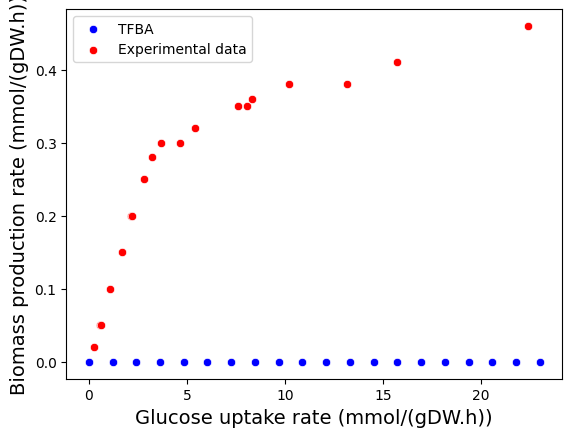

In [48]:
#plot biomass yield for stoichiometric model with balanced reactions and pH specified
df_data2 = pd.read_csv(f'{INPUT_FOLDER}plotting_Yeast_ALL_experimental_data.csv',index_col=0)
df_data2['regression'].fillna('Not fitted',inplace=True)
df_data2['regression'].replace('yes', 'Fitted', inplace=True)
df_data2.rename(columns={'regression':'Exp. data'}, inplace=True)
#rename index in Condition
df_data2.index.rename('Condition', inplace=True)

GUR_plot_range=[-x for x in GUR_range]
#plot biomass vs GUR in a scatter plot

sns.scatterplot(x=GUR_plot_range,y=fluxes_gdiss.loc['biomass_EX'],color='b',label='TFBA')
sns.scatterplot(x=df_data2['glc-D_EX'], y=df_data2['biomass_EX'], color=['red'],label='Experimental data')

plt.xlabel('Glucose uptake rate (mmol/(gDW.h))',fontsize=14)
plt.ylabel('Biomass production rate (mmol/(gDW.h))',fontsize=14)


